In [1]:
import torch
import numpy as np
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

alpha = 0.1
K = 1000
B = 128
N = 512
n0, n1, n2, n3 = (1, 64, 64, 1)

def f_true(x) :
    return (x-2) * np.cos(x*4)

torch.manual_seed(0)
X_train = torch.normal(0.0, 1.0, (N,))
y_train = f_true(X_train)
X_val = torch.normal(0.0, 1.0, (N//5,))
y_val = f_true(X_val)

train_dataloader = DataLoader(TensorDataset(X_train.unsqueeze(1), y_train.unsqueeze(1)), batch_size=B)
test_dataloader = DataLoader(TensorDataset(X_val.unsqueeze(1), y_val.unsqueeze(1)), batch_size=B)

'''
unsqueeze(1) reshapes the data into dimension [N,1],
where is 1 the dimension of an data point.

The batchsize of the test dataloader should not affect the test result
so setting batch_size=N may simplify your code.
In practice, however, the batchsize for the training dataloader
is usually chosen to be as large as possible while not exceeding
the memory size of the GPU. In such cases, it is not possible to
use a larger batchsize for the test dataloader.
'''

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(n0, n1, bias=True)
        self.l2 = nn.Linear(n1, n2, bias=True)
        self.l3 = nn.Linear(n2, n3, bias=True)
    def forward(self, x):
        a1 = torch.sigmoid(self.l1(x))
        a2 = torch.sigmoid(self.l2(a1))
        z3 = self.l3(a2)
        return z3
    
model = MLP()
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss = nn.MSELoss()

'''
When plotting torch tensors, you want to work with the
torch.no_grad() context manager.

When you call plt.plot(...) the torch tensors are first converted into
numpy arrays and then the plotting proceeds.
However, our trainable model has requires_grad=True to allow automatic
gradient computation via backprop, and this option prevents 
converting the torch tensor output by the model to a numpy array.
Using the torch.no_grad() context manager resolves this problem
as all tensors are set to requires_grad=False within the context manager.

An alternative to using the context manager is to do 
plt.plot(xx, model(xx).detach().clone())
The .detach().clone() operation create a copied pytorch tensor that
has requires_grad=False.

To be more precise, .detach() creates another tensor with requires_grad=False
(it is detached from the computation graph) but this tensor shares the same
underlying data with the original tensor. Therefore, this is not a genuine
copy (not a deep copy) and modifying the detached tensor will affect the 
original tensor is weird ways. The .clone() further proceeds to create a
genuine copy of the detached tensor, and one can freely manipulate and change it.
(For the purposes of plotting, it is fine to just call .detach() without
.clone() since plotting does not change the tensor.)

This discussion will likely not make sense to most students at this point of the course.
We will revisit this issue after we cover backpropagation.

'''



tensor([-1.1258e+00, -1.1524e+00, -2.5058e-01, -4.3388e-01,  8.4871e-01,
         6.9201e-01, -3.1601e-01, -2.1152e+00,  3.2227e-01, -1.2633e+00,
         3.4998e-01,  3.0813e-01,  1.1984e-01,  1.2377e+00,  1.1168e+00,
        -2.4728e-01, -1.3527e+00, -1.6959e+00,  5.6665e-01,  7.9351e-01,
         5.9884e-01, -1.5551e+00, -3.4136e-01,  1.8530e+00,  7.5019e-01,
        -5.8550e-01, -1.7340e-01,  1.8348e-01,  1.3894e+00,  1.5863e+00,
         9.4630e-01, -8.4368e-01, -6.1358e-01,  3.1593e-02, -4.9268e-01,
         2.4841e-01,  4.3970e-01,  1.1241e-01,  6.4079e-01,  4.4116e-01,
        -1.0231e-01,  7.9244e-01, -2.8967e-01,  5.2507e-02,  5.2286e-01,
         2.3022e+00, -1.4689e+00, -1.5867e+00, -6.7309e-01,  8.7283e-01,
         1.0554e+00,  1.7784e-01, -2.3034e-01, -3.9175e-01,  5.4329e-01,
        -3.9516e-01, -4.4622e-01,  7.4402e-01,  1.5210e+00,  3.4105e+00,
        -1.5312e+00, -1.2341e+00,  1.8197e+00, -5.5153e-01, -5.6925e-01,
         9.1997e-01,  1.1108e+00,  1.2899e+00, -1.4

'\nWhen plotting torch tensors, you want to work with the\ntorch.no_grad() context manager.\n\nWhen you call plt.plot(...) the torch tensors are first converted into\nnumpy arrays and then the plotting proceeds.\nHowever, our trainable model has requires_grad=True to allow automatic\ngradient computation via backprop, and this option prevents \nconverting the torch tensor output by the model to a numpy array.\nUsing the torch.no_grad() context manager resolves this problem\nas all tensors are set to requires_grad=False within the context manager.\n\nAn alternative to using the context manager is to do \nplt.plot(xx, model(xx).detach().clone())\nThe .detach().clone() operation create a copied pytorch tensor that\nhas requires_grad=False.\n\nTo be more precise, .detach() creates another tensor with requires_grad=False\n(it is detached from the computation graph) but this tensor shares the same\nunderlying data with the original tensor. Therefore, this is not a genuine\ncopy (not a deep c

Time elapsed in training is: 4.022273063659668


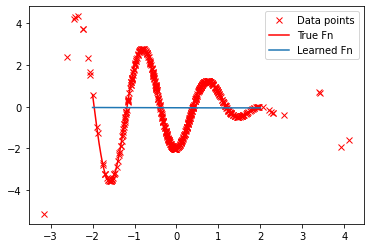

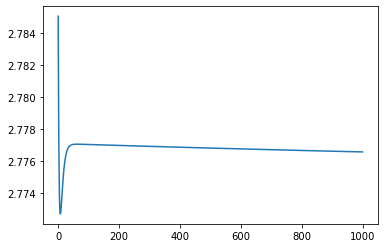

In [2]:
import time, random
start = time.time()
losses = []
for _ in range(1000):
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()  # clear gradient
        # if _ == 0:
        #     print(batch_x)
        train_loss = loss(model(batch_x), batch_y)  # calculate train_loss
        train_loss.backward()  # backpropagation
        optimizer.step()  # gradient descent
    if _%1 == 0:
        losses.append(train_loss.detach().item())
end = time.time()
print(f"Time elapsed in training is: {end-start}")
plt.figure(0)
with torch.no_grad():
    xx = torch.linspace(-2,2,1024).unsqueeze(1)
    plt.plot(X_train, y_train, 'rx', label='Data points')
    plt.plot(xx, f_true(xx), 'r', label='True Fn')
    plt.plot(xx, model(xx), label='Learned Fn')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(losses)
plt.show()
